- Claim, "you would like this restaurant"
- Evidence, "Cause you used to like A and B aspects" (based on the importance on aspects)
- Evidence, "Similar users also visited this restaurant"

In [1]:
import pandas as pd;
import numpy as np;
from collections import defaultdict;
from nltk.stem.wordnet import WordNetLemmatizer;
lemma = WordNetLemmatizer();

In [2]:
restaurants = pd.read_parquet('restaurants_reviews_with_aspects_polarities');
users = pd.read_parquet('users_reviews_with_aspects_polarities');

In [3]:
def getScore(sentiment):
    if sentiment == 'Positive':
        return 1;
    elif sentiment == 'Negative':
        return -1;
    else:
        return 0;

def reviewAspects(dic):
    def inner(aspect_polarity_pairs):
        for pair in aspect_polarity_pairs:
            aspects, sentiments = pair['aspect'], pair['sentiment'];
            for i, aspect in enumerate(aspects):
                aspect = lemma.lemmatize(lemma.lemmatize(aspect, pos='v'), pos='n');
                dic[aspect][0] += getScore(sentiments[i]);
                if sentiments[i] == 'Positive':
                    dic[aspect][1] += 1;
                if sentiments[i] == 'Negative':
                    dic[aspect][2] += 1;
                dic[aspect][3] += 1;
    return inner;

Format for aspect: [Overall score = POS-NEG, Positive CNT, Negative CNT, Total CNT=POS+NEG+NEUTRAL]

In [4]:
# Get the aspects and score of them of restaurants
restaurant_aspects = {};
for business in restaurants['business_id'].unique():
    dic = defaultdict(lambda: [0, 0, 0, 0]);
    restaurants.groupby('business_id').get_group(business)['aspect_polarity'].apply(reviewAspects(dic));
    # dic = sorted(dic.items(), key=lambda x: x[1], reverse=True);
    restaurant_aspects[business] = dic;

In [5]:
# Get the aspects and score of them of users
user_aspects = {};
for user in users['user_id'].unique():
    dic = defaultdict(lambda: [0, 0, 0, 0]);
    users.groupby('user_id').get_group(user)['aspect_polarity'].apply(reviewAspects(dic));
    # dic = sorted(dic.items(), key=lambda x: x[1], reverse=True);
    user_aspects[user] = dic;

In [6]:
REST_DICTIONARY = set();
for dic in restaurant_aspects.values():
    for key in dic:
        REST_DICTIONARY.add(key);

USER_DICTIONARY = set();
for dic in user_aspects.values():
    for key in dic:
        USER_DICTIONARY.add(key);

DICTIONARY = REST_DICTIONARY.union(USER_DICTIONARY);
        
# dictionary containing all the aspects
dictionary = list(DICTIONARY);
user_dictionary = list(USER_DICTIONARY);
restaurant_dictionary = list(REST_DICTIONARY);

---
### Importance of aspects

**Concern, requirements and importance**

Caculation of concern:  
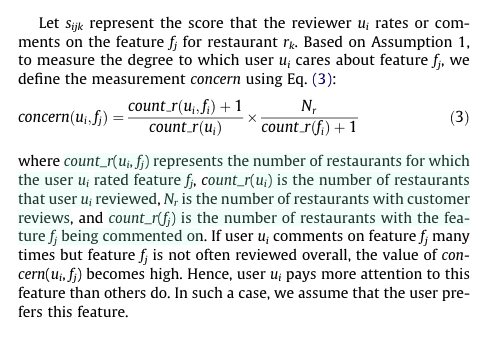

Caculation of requirement:   
NOTE: The calculation of requirements are unable to be finished, since we use the sentiment score but not rate from users.  
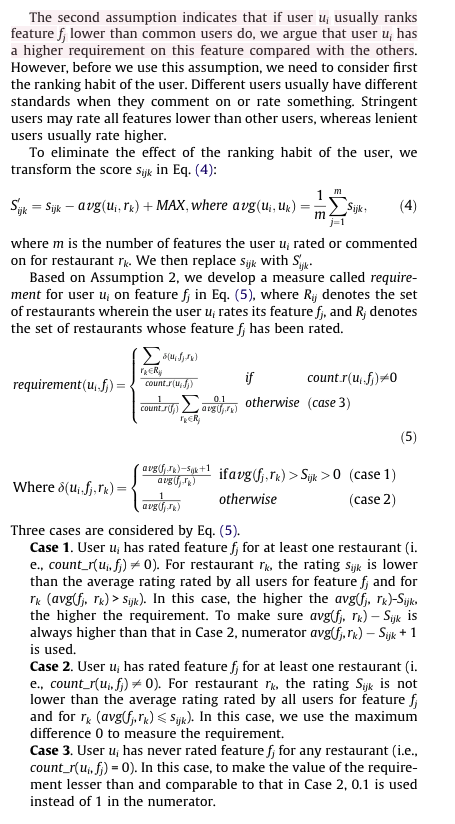

Importance  
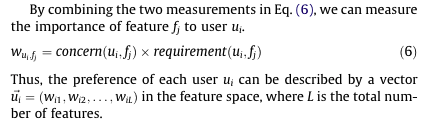

In [7]:
# Aspects set of each restaurant
restaurant_aspects_set = {};
for restaurant in restaurant_aspects:
    restaurant_aspects_set[restaurant] = set(restaurant_aspects[restaurant].keys());

In [8]:
# Count the frequency of each aspect shown in restaurants
aspect_restaurant_freq = defaultdict(int);
for aspect in restaurant_dictionary:
    for restaurant in restaurant_aspects_set:
        if aspect in restaurant_aspects_set[restaurant]:
            aspect_restaurant_freq[aspect] += 1;

In [9]:
user_concerns = {};
restaurants_total = restaurants['business_id'].unique().size;

for user_id in user_aspects.keys():
    user = user_aspects[user_id].copy();
    restaurants_visited = users.groupby('user_id').get_group(user_id)['business_id'].unique().size;
    for aspect in user:
        if aspect in restaurant_dictionary:
            user[aspect] = [((user[aspect][3]+1)/restaurants_visited)*np.log(restaurants_total/(aspect_restaurant_freq[aspect]+1)), user[aspect][3]];
        else: # if the aspect doesn't show in the restaurant_dictionary, assign 0
            user[aspect] = [0, user[aspect][3]];
        user = dict(sorted(user.items(), key=lambda x: x[1], reverse=True));
        user_concerns[user_id] = user;

In [10]:
user_requirements = {};
for user in user_aspects:
    u_aspects = user_aspects[user].copy();
    res = {};
    for aspect in u_aspects:
        res[aspect] = u_aspects[aspect][2]/u_aspects[aspect][3] if u_aspects[aspect][3]>1 else 0; # user should mention an aspect at least twice
    user_requirements[user] = res;

In [11]:
user_importance = {};
for user_id in user_concerns:
    user_dict = {};
    user = user_concerns[user_id];
    for aspect in user:
        user_dict[aspect] = user[aspect][0]*(1+user_requirements[user_id][aspect]);
    user_dict = dict(sorted(user_dict.items(), key=lambda x: x[1], reverse=True));
    user_importance[user_id] = user_dict;

TODO: How to handling mistakes like 'desert' which is intended to be 'dessert'?

In [50]:
# # Calculate the average score of aspects in each restaurant
# restaurant_aspect_avg_score = {};
# for restaurant in restaurant_aspects:
#     r_aspects = restaurant_aspects[restaurant].copy();
#     res = {};
#     for aspect in r_aspects:
#         res[aspect] = r_aspects[aspect][2]/r_aspects[aspect][3] if r_aspects[aspect][3]>1 else 0;
#     restaurant_aspect_avg_score[restaurant] = res;
    
# # Get the aspect score of each restaurant for users
# def userRestaurantAspects(dic):
#     def inner(aspect_polarity_pairs):
#         for pair in aspect_polarity_pairs:
#             aspects, sentiments = pair['aspect'], pair['sentiment'];
#             for i, aspect in enumerate(aspects):
#                 aspect = lemma.lemmatize(aspect);
#                 dic[aspect] += getScore(sentiments[i]);
#     return inner;

# user_restaurant_aspects = {};
# for user_id in users['user_id'].unique():
#     user = users.groupby('user_id').get_group(user_id);
#     bussiness = user['business_id'].unique();
#     restaurant_dic = {};
#     for restaurant in bussiness:
#         dic = defaultdict(int);
#         restaurant_dic[restaurant] = dic;
#         user.groupby('business_id').get_group(restaurant)['aspect_polarity'].apply(userRestaurantAspects(dic));
#     user_restaurant_aspects[user_id] = restaurant_dic;
    
# user_aspect_restaurants = {};
# for user_id in user_restaurant_aspects:
#     dic = defaultdict(dict);
#     user = user_restaurant_aspects[user_id];
#     for restaurant_id in user:
#         restaurant = user[restaurant_id];
#         for aspect in restaurant:
#             dic[aspect][restaurant_id] = restaurant[aspect];
#     user_aspect_restaurants[user_id] = dic;

# for user_id in user_aspect_restaurants:
#     user = user_aspect_restaurants[user_id];
#     for aspect_id in user:
#         aspect = user[aspect_id];
#         for restaurant_id in aspect:
#             print(user_id, aspect_id, restaurant_id)
#             if restaurant_aspect_avg_score[restaurant_id][aspect_id] > user[aspect_id][restaurant_id]:
#                 user[aspect_id][restaurant_id] = True;
#             else:
#                 user[aspect_id][restaurant_id] = False;

---
### Recommendation

In [12]:
dictionary_numpy = np.array(dictionary);

In [13]:
def userAspectToVector(uid, _aspects):
    aspects = _aspects[uid];
    vector = np.zeros(dictionary_numpy.size, dtype='object');
    for aspect, importance in aspects.items():
        index = np.where(dictionary_numpy==aspect)[0][0];
        vector[index] = importance;
    return np.insert(vector, 0, uid);

In [14]:
user_importances = pd.DataFrame(columns=np.insert(dictionary, 0, 'user_id'));
for user in user_importance:
    user_importances.loc[len(user_importances.index)] = userAspectToVector(user, user_importance);

In [20]:
def restaurantAspectToVector(rid, _aspects):
    aspects = _aspects[rid];
    vector = np.zeros(dictionary_numpy.size, dtype='object');
    for aspect, score in aspects.items():
        index = np.where(dictionary_numpy==aspect)[0][0];
        vector[index] = score[0];
    return np.insert(vector, 0, rid);

In [21]:
restaurant_scores = pd.DataFrame(columns=np.insert(dictionary, 0, 'r_id'));
for restaurant in restaurant_aspects:
    restaurant_scores.loc[len(restaurant_scores.index)] = restaurantAspectToVector(restaurant, restaurant_aspects);

In [31]:
restaurant_scores_data = restaurant_scores.to_numpy();
restaurant_scores_data = np.delete(restaurant_scores_data, 0, axis=1);

In [44]:
user_importances_data = user_importances.to_numpy();
user_importances_data = np.delete(user_importances_data, 0, 1);

In [127]:
user_restaurant_rs_scores = {};
user_ids = user_importances['user_id'].values;
restaurant_ids = restaurant_scores['r_id'].values
get_value = lambda x: x[0];

for i in range(user_importances_data.shape[0]):
    scores = restaurant_scores_data*user_importances_data[i];
    rs_scores = [(np.sum(score), score) for score in scores];
    user_dict = dict(zip(restaurant_ids, rs_scores));
    user_dict = {k: v for k, v in sorted(user_dict.items(), key=lambda item: item[1][0], reverse=True)}
    user_restaurant_rs_scores[user_ids[i]] = user_dict;

In [130]:
def analyseScores(scores):
    dic = dict(zip(dictionary_numpy, scores));
    return {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)};

---

### Variation: Cluster aspects into specific groups (Method 2)

IDEA: use word embedding from spacy to compute the cosine similarity between words

- Food
    - 'food', 'dessert', 'drink', 'dipping'
- Ambience
    - 'ambinece', 'decoration'
- Service
    - 'service', 'staff'
- Location

In [7]:
import spacy;
nlp = spacy.load("en_core_web_lg");

2022-08-13 12:38:44.614177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-13 12:38:44.614209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-13 12:38:48.667129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-13 12:38:48.667167: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-13 12:38:48.667192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist


In [8]:
dictionary_vector = np.array([nlp(word).vector for word in dictionary]);

In [10]:
dictionary_vector_norm = np.array([nlp(word).vector_norm for word in dictionary]);
dictionary_vector_norm = dictionary_vector_norm.reshape(-1, 1);

In [11]:
dictionary_vector_norm_matrix = np.dot(dictionary_vector_norm, dictionary_vector_norm.T);
dictionary_vector_matrix = np.dot(dictionary_vector, dictionary_vector.T);

In [12]:
similarity_matrix = dictionary_vector_matrix/dictionary_vector_norm_matrix
# Fill nan with 0
similarity_matrix = np.nan_to_num(similarity_matrix, nan=0);
similarity_matrix = np.around(similarity_matrix, 5);

/tmp/ipykernel_96/509002279.py:1: RuntimeWarning: invalid value encountered in true_divide
  similarity_matrix = dictionary_vector_matrix/dictionary_vector_norm_matrix


In [13]:
def distance(x, y):
    try:
        index_x, index_y = dictionary.index(x), dictionary.index(y);
        return 1-abs(similarity_matrix[index_x][index_y]);
    except:
        print('ERROR', x, y);
        return 2;

num = len(dictionary);
label = np.zeros(num);
dists = np.zeros(num);
for i in range(num):
    min_dist = 2; # The maximum distance bewtween two aspects is within 2, i.e. 1-(-1) = 2
    for j, keyword in enumerate(['food', 'dessert', 'drink', 'dipping',
                                  'decoration', 'ambience',
                                  'staff', 'service',
                                  'price',
                                  'location']):
        dist = distance(dictionary[i], keyword);
        if dist < min_dist:
            min_dist = dist;
            label[i] = j;
            dists[i] = dist;

In [14]:
dictionary = np.array(dictionary);

In [15]:
food_words = dictionary[label==0];
food_dists = dists[label==0];

In [16]:
food_words

array(['kenzinger', 'parrillada', 'beck', 'churcos', 'chicken fat',
       'meatschima', 'water dish', 'milk / cream', 'grub', 'store',
       'fresh mozarella', 'knackwurst', 'staffcons', 'dacquoise',
       'inner meat', 'extra beef', 'meat portion', 'ethio', 'traci',
       'daily', 'foodery', 'yekik alicha', 'meat', 'tripel', 'andalusian',
       'peshwari', 'lobsterfest', 'lobster macaroni and cheese',
       'chilled lobster meat', 'sangaritas', 'estia', 'fried food',
       'indian food', 'pilsener', 'mexican', 'fritattas', 'buddakhan',
       'biergarten', 'inside restaurant', 'ricker', 'aksum', 'marscapone',
       'sopes', 'air', 'food quantity', 'diet', 'bar food',
       'daily fish specials', 'spatzle', 'plaing', 'shoppe',
       'mediterranean food', 'mussel', 'lassoni', 'beef option', 'hunger',
       'gourmet olive oil', 'gruner', 'rice milk', 'bacon and potato',
       'chipoltle', 'quality of food', 'dessertsi', 'flanksteak',
       'garces', 'gewürztraminer', 'minced

In [17]:
beverage_words = dictionary[label==1];
beverage_dists = dists[label==1];

In [18]:
service_words = dictionary[label==2];
service_dists = dists[label==2];

In [19]:
price_words = dictionary[label==3];
price_dists = dists[label==3];

In [20]:
location_words = dictionary[label==4];
location_dists = dists[label==4];

In [21]:
ambience_words = dictionary[label==5];
ambience_dists = dists[label==5];

In [22]:
def similarity(a, b):
    return nlp(a).similarity(nlp(b));

In [23]:
similarity('ketchup', 'dessert'), similarity('ketchup', 'dipping')

(0.5272892623715159, 0.33097992310011537)

---

Convert aspects to vector and make clustering.

In [73]:
DICTIONARY = set();

for dic in restaurant_aspects.values():
    for key in dic:
        DICTIONARY.add(key);
        
for dic in user_aspects.values():
    for key in dic:
        DICTIONARY.add(key);
        
# dictionary containing all the user aspects
dictionary = np.array(list(DICTIONARY));

In [74]:
def aspect_to_vector(uid, _aspects):
    aspects = _aspects[uid];
    vector = np.zeros(len(dictionary), dtype='object');
    for aspect, scores in aspects.items():
        index = np.where(dictionary==aspect)[0][0];
        vector[index] = scores[0];
    return np.insert(vector, 0, uid);

In [119]:
user_df = pd.DataFrame(columns=np.insert(dictionary, 0, 'user_id'));
for user in user_aspects:
    user_df.loc[len(user_df.index)] = aspect_to_vector(user, user_aspects);

In [120]:
restaurant_df = pd.DataFrame(columns=np.insert(dictionary, 0, 'restaurant_id'));
for restaurant in restaurant_aspects:
    restaurant_df.loc[len(restaurant_df.index)] = aspect_to_vector(restaurant, restaurant_aspects);

In [125]:
sample = user_df[user_df.columns[~user_df.columns.isin(['user_id'])]].iloc[0].to_numpy();

In [105]:
from scipy import spatial;

In [127]:
test = restaurant_df[restaurant_df.columns[~restaurant_df.columns.isin(['restaurant_id'])]].to_numpy();

In [129]:
res = [];
for row in test:
    res.append(spatial.distance.cosine(row, sample));

In [135]:
pd.DataFrame({'rid': restaurant_df['restaurant_id'].to_numpy(), 'score': res}).sort_values(by=['score'], ascending=False)

,rid,score
57,Yu401DtSmkXpJhgXnQcFrg,1.048280
30,JHRlwxxKY0JJcU97rJ-Bug,1.036648
7,17MK8qagV374AuUA4sXuIA,1.002860
49,SDL247FlOnScJfuNjZESxg,0.956376
86,pP_jeWrWq-lvMitmkM2Gkw,0.947547
...,...,...
87,qBwOLby0sOJd3QG1o76W2w,0.403810
68,ctHjyadbDQAtUFfkcAFEHw,0.403199
67,ckbvLKwjEb836t-EDKsVVg,0.394557
93,tYn8hGpZiRgJ8cP2FcI_YQ,0.385897


---

In [67]:
from tqdm import tqdm;

In [68]:
class KMedoids():
    
    def __init__(self, data, k, r):
        self.data = np.array(data);
        self.k = k;
        self.r = r;
        self.E = np.zeros(k);
        self.label = np.empty(len(data));
        self.centroids = self.__init(data, k ,r);
        self._convergence = False;
    
    def __distance(self, x, y):
        try:
            index_x, index_y = dictionary.index(x), dictionary.index(y);
            return 1-similarity_matrix[index_x][index_y];
        except:
            print('ERROR', x, y);
            return 2;

    
    def __init(self, data, k, r):
        '''
        Initialize centroids
        '''
        # rs = np.random.RandomState(r);
        # random_ids = rs.randint(len(data), size=k);
        # centroids = np.empty(k, dtype=object);
        # for i, random_id in enumerate(random_ids):
        #     centroids[i] = data[random_id];
        # return centroids;
        return np.array(['food', 'drink', 'staff', 'price', 'location', 'ambience'], dtype='object');
    
    def __converge(self, pre):
        return True if False not in (pre==self.centroids) else False;
    
    # def __update(self):
    #     while(self._convergence):
    #         pre_centroids = self.centroids.copy();
    #         for i in range(self.k):
    #             aspects_group = self.data[self.label==i];
    #             for index, candidate in enumerate(aspects_group):
    #                 clear();
    #                 print(f'search through candidate for cluster {i}: {index/len(aspects_group)}');
    #                 if candidate not in self.centroids:
    #                     pre_cost, new_cost = self.E[i], 0;
    #                     for aspect in aspects_group:
    #                         new_cost += self.__distance(candidate, aspect);
    #                     if new_cost - pre_cost < 0:
    #                         self.centroids[i] = candidate;
    #         self.__label();
    #         self._convergence = self.__converge(pre_centroids);
    
    def __label(self):
        num = len(self.data);
        self.E = np.zeros(self.k); # Renew the costs
        for i in range(num):
            min_dist = 2; # The maximum distance bewtween two aspects is within 2, i.e. 1-(-1) = 2
            for j in range(self.k):
                dist = self.__distance(self.data[i], self.centroids[j]);
                if dist < min_dist:
                    min_dist = dist;
                    self.label[i] = j;
            self.E[int(self.label[i])] += self.__distance(self.data[i], self.centroids[int(self.label[i])]);
    
    def fit(self):
        # Initialize the labels of each aspect
        self.__label();
        
        iteration = 0;
        while(not self._convergence):
            print(f'iteration {iteration} with E {np.sum(self.E)}');
            pre_centroids = self.centroids.copy();
            for i in range(self.k):
                print(f'search through candidate for cluster {i}');
                aspects_group = self.data[self.label==i];
                for candidate in tqdm(aspects_group):
                    if candidate not in self.centroids:
                        pre_cost, new_cost = self.E[i], 0;
                        for aspect in aspects_group:
                            new_cost += self.__distance(candidate, aspect);
                        if new_cost - pre_cost < 0:
                            self.centroids[i] = candidate;
            self.__label();
            self._convergence = self.__converge(pre_centroids);
            iteration += 1;
        
        # update centroids
        # self.__update();